In [1]:
# general libraries
import numpy as np
import pandas as pd
import time
import sys
import matplotlib.pyplot as plt

# tensorflow libraries
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# sklearn libraries
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 

2024-08-18 15:12:46.692032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 15:12:48.365268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.metrics import silhouette_score

In [3]:
!git clone https://github.com/toelt-llc/ADL-Book-2nd-Ed.git

fatal: il percorso di destinazione 'ADL-Book-2nd-Ed' esiste già e non è una directory vuota.


In [4]:
import sys
sys.path.append('ADL-Book-2nd-Ed/modules/')

from plot_confusion_matrix import plot_cm

In [5]:
from keras.datasets import mnist

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

In [6]:
mnist_x_train = mnist_x_train.astype('float32') / 255.
mnist_x_test = mnist_x_test.astype('float32') / 255.
mnist_x_train = mnist_x_train.reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
mnist_x_test = mnist_x_test.reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))

In [7]:
def create_autoencoders(feature_layer_dim = 16):

  input_img = Input(shape = (784,), name = 'Input_Layer')
  # 784 is the total number of pixels of MNIST images
  
  # The layer encoded has a dimension equal to feature_layer_dim and contains
  # the encoded input (therefore the name)
  encoded = Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
  decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)

  encoded_input = Input(shape = (feature_layer_dim,))
  decoder = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder(encoded_input))

  return autoencoder, encoder, decoder

In [8]:
# 16 is the number of latent features of our autoencoder
autoencoder, encoder, decoder = create_autoencoders(256) 

In [9]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [10]:
history = autoencoder.fit(mnist_x_train, mnist_x_train,
                          epochs = 30,
                          batch_size = 256,
                          shuffle = True,
                          validation_data = (mnist_x_test, mnist_x_test),
                          verbose = 0)

2024-08-18 15:12:52.977838: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-08-18 15:12:53.764721: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-08-18 15:12:57.734389: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2024-08-18 15:12:57.859547: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


In [11]:
encoded_imgs = encoder.predict(mnist_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-08-18 15:14:07.722084: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


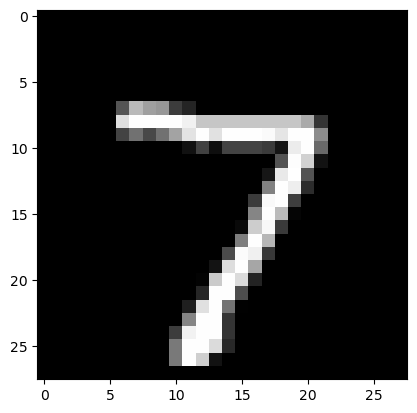

In [12]:
img = mnist_x_test[0]
plt.imshow(img.reshape(28, 28), cmap = 'gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


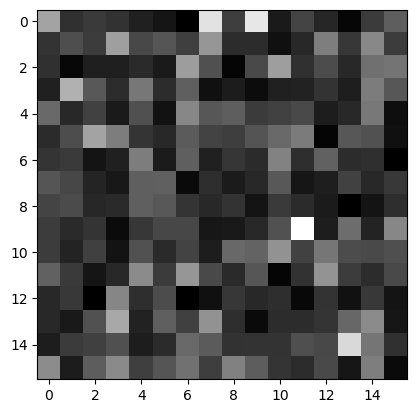

In [13]:
plt.imshow(encoder.predict(img.reshape(1, 784)).reshape(16, 16), cmap = 'gray')

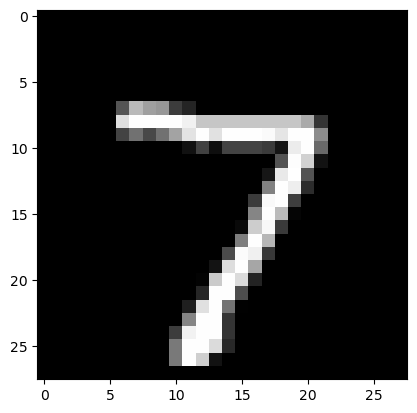

In [14]:
U, s, VT = np.linalg.svd(img.reshape(28,28), full_matrices=False)
r = 16
recontructed_img = U[:,:(r+1)] @ np.diag(s[:(r+1)]) @ VT[:(r+1),:]
plt.imshow(recontructed_img, cmap = 'gray')

Text(0.5, 1.0, 'explained variance')

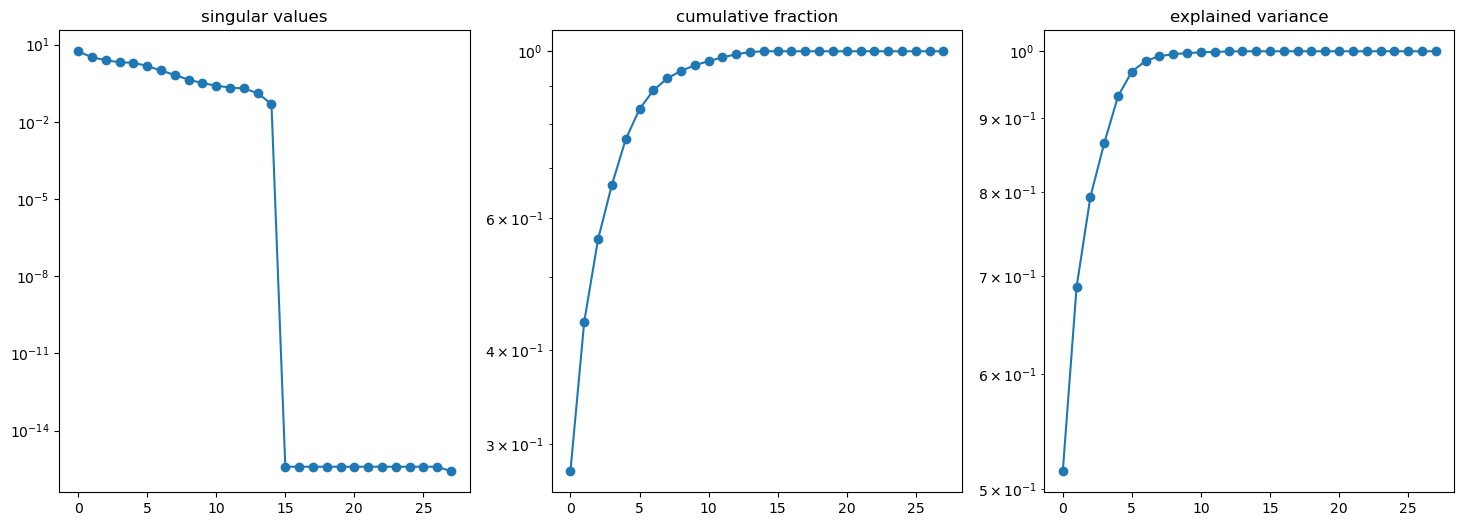

In [15]:
U, s, VT = np.linalg.svd(img.reshape(28,28), full_matrices=False)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
axs[0].semilogy(s, "o-")
axs[0].set_title("singular values")
axs[1].semilogy(np.cumsum(s) / np.sum(s), "o-")
axs[1].set_title("cumulative fraction")
axs[2].semilogy(np.cumsum(s**2) / np.sum(s**2), "o-")
axs[2].set_title("explained variance")

In [16]:
kmeans = KMeans(n_clusters=10, n_init=100)
kmeans.fit(encoded_imgs)

# Step 2: Obtain the cluster labels for each data point
labels = kmeans.labels_


pca = PCA(n_components=3)
pca.fit(encoded_imgs)
pca_results = pca.transform(encoded_imgs)
#pca_results.shape

df = pd.DataFrame(np.hstack((pca_results,labels.reshape(10000, 1))), columns = ['PCA1', 'PCA2', 'PCA3','labels'])
fig = px.scatter_3d(df, x='PCA1', y='PCA2', z='PCA3',
              color='labels')
fig.show()

print('Silhouette Score: ', silhouette_score(encoded_imgs, labels))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fcb13a07920>
Traceback (most recent call last):
  File "/home/lorenzobozzoni/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/lorenzobozzoni/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lorenzobozzoni/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/lorenzobozzoni/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeErro

Silhouette Score:  0.06820083


In [17]:
kmeans = KMeans(n_clusters=10, n_init=100)
kmeans.fit(mnist_x_test)

# Step 2: Obtain the cluster labels for each data point
labels = kmeans.labels_


pca = PCA(n_components=3)
pca.fit(encoded_imgs)
pca_results = pca.transform(encoded_imgs)
#pca_results.shape

df = pd.DataFrame(np.hstack((pca_results,labels.reshape(10000, 1))), columns = ['PCA1', 'PCA2', 'PCA3','labels'])
fig = px.scatter_3d(df, x='PCA1', y='PCA2', z='PCA3',
              color='labels')
fig.show()

print('Silhouette Score: ', silhouette_score(encoded_imgs, labels))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fcb81c33600>
Traceback (most recent call last):
  File "/home/lorenzobozzoni/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/lorenzobozzoni/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lorenzobozzoni/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/lorenzobozzoni/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeErro

Silhouette Score:  0.027165966


Let's compare the reconstructed images while changing the hidden layer size.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


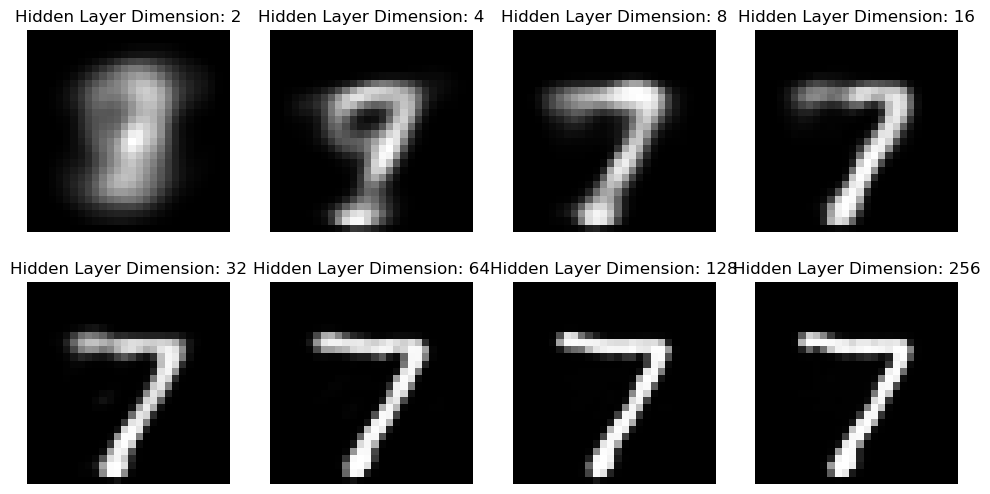

In [20]:
hidden_layer_dims = [2, 4, 8, 16, 32, 64, 128, 256]
reconstructed_imgs = []

for i in hidden_layer_dims:
  autoencoder, encoder, decoder = create_autoencoders(int(i))
  autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

  history = autoencoder.fit(mnist_x_train, mnist_x_train,
                            epochs = 30,
                            batch_size = 256,
                            shuffle = True,
                            validation_data = (mnist_x_test, mnist_x_test),
                            verbose = 0)

  encoded_imgs = encoder.predict(mnist_x_test)
  decoded_imgs = decoder.predict(encoded_imgs)
  reconstructed_imgs.append(decoded_imgs[0])

fig, axs = plt.subplots(nrows=2, ncols=int(len(hidden_layer_dims)/2), figsize=(12, 6))
axs = axs.flatten()
for i in range(len(hidden_layer_dims)):
    axs[i].imshow(reconstructed_imgs[i].reshape(28, 28), cmap = 'gray')
    axs[i].set_title('Hidden Layer Dimension: ' + str(hidden_layer_dims[i]))
    axs[i].axis('off')

In [25]:
from scipy import linalg

(np.linalg.norm(autoencoder.get_weights()[0], ord='fro') - linalg.norm(autoencoder.get_weights()[2], ord='fro')) / np.linalg.norm(autoencoder.get_weights()[0], ord='fro')

0.20572717

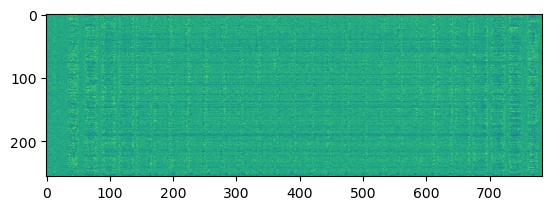

In [33]:
plt.imshow((autoencoder.get_weights()[2] - autoencoder.get_weights()[0].T)*100)

In [32]:
(autoencoder.get_weights()[2] - autoencoder.get_weights()[0].T)*100

array([[-23.170904  ,  -5.229439  ,  -7.6868477 , ..., -11.768404  ,
        -25.015831  , -23.809322  ],
       [ -9.589749  ,   0.41482252,  -9.08699   , ...,   6.0243583 ,
          9.20647   , -15.688372  ],
       [-10.656727  ,  -8.526005  ,  -6.4643917 , ...,  -4.531546  ,
          2.0087578 ,  -3.1064327 ],
       ...,
       [ -2.7666802 ,  -4.9957747 ,  -7.641159  , ...,   6.45601   ,
         -1.9606769 ,   9.293922  ],
       [ -6.6157045 ,  -2.2884483 ,   2.7165835 , ...,   4.9198136 ,
          4.359322  ,  11.675468  ],
       [ -4.2837725 , -11.915226  ,   5.08619   , ...,  -0.8869804 ,
         -8.7254505 ,   0.826605  ]], dtype=float32)